In [271]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K, Sequential, Input, Model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, \
    TimeDistributed, RepeatVector, Dropout, GRU, AveragePooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, \
    precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE

In [2]:
def threshold_for_max_f1(y_real, Yhat):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this func not necessarily optimized, could return to 
    doing this but not needed).
    
    Also note that we calculate f1 without using the results method
    in keras_model. This is because we need to check beforehand that
    computing f1 won't produce a NaN so we won't get an invalid value warning.
    '''
    
    #error is occuring in km.results when computing f1, because TNR, NPV are 0, implying that there
    #are no true negatives. While we added if statements to account for at least one predicted
    #negative, this does not correlate to at least one true negative. Hence, instead of using keras.results
    #we use that code by check that tn is not 0
    f1_vals = []
    for i in range(0, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

        cm = confusion_matrix(y_real, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_real, y_predict).ravel()
        
        if tn != 0:      
            TNR = (tn) / (tn + fp)
            NPV = (tn) / (tn + fn)
            f1 = 2 * (TNR * NPV) / (TNR + NPV)
        else:
            f1 = -2   
        f1_vals.append(f1)
        
    f1_vals = np.array(f1_vals)
    f1_vals = np.nan_to_num(f1_vals, nan=-1)
    return (np.argmax(f1_vals))/100

In [3]:
def plot_cf_matrix(y_real, y_predict):
    '''
    Given y_real and y_predict, this method displays the results
    (accuracy, recall, precision, f1) followed by the plot of the confusion matrix.
    '''
    print(km.results(y_real, y_predict), '\n')
    
    classes = ['High_svi', 'Low_svi']
    cm = confusion_matrix(y_real, y_predict)
    sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [4]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [5]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [6]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [36]:
reactor_list[1]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,94.066570,22.030,0.22,2.92
2010-01-02,95.318860,21.985,0.22,3.04
2010-01-03,82.826748,21.740,0.22,3.00
2010-01-04,95.307918,21.815,0.22,2.97
2010-01-05,93.930636,21.890,0.23,2.94
...,...,...,...,...
2020-12-27,144.736842,22.540,0.23,3.41
2020-12-28,130.890052,22.535,0.24,3.10
2020-12-29,140.306122,22.660,0.25,3.15


In [8]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [9]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [12]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [100]:
join_list[0]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-10-28,117.302053,27.165,0.24,3.32,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-29,194.174757,27.495,0.24,3.09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-30,153.714774,27.055,0.24,3.39,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-31,177.165354,26.720,0.25,2.74,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-01,171.113626,26.380,0.25,3.43,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-02,165.061898,26.210,0.25,3.47,15.0,14.0,2.0,0.0,13.0,1.0,...,NaN,NaN,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2010-11-03,154.241645,25.915,0.25,2.54,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-04,123.667377,25.620,0.24,2.23,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-11-05,122.850123,25.965,0.23,2.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#model without resampling

In [142]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
X_normalize = np.nan_to_num(X_normalize, nan=-1)

100%|██████████| 7/7 [00:00<00:00, 52.57it/s]


In [132]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

Epoch 1/3
10570/14439 [====================>.........] - ETA: 4s - loss: nan - binary_accuracy: 0.3222

KeyboardInterrupt: 

In [ ]:
plot_cf_matrix(y_real, y_predict)

In [26]:
#model with resampling

In [272]:
def over_sample(X, Y, sampler):
    '''
    This function over samples data X and labels Y. Because each piece of data is 2D (hence X is 3D),
    we need to do some clever resizing since the imblearn Oversampling functions only work with a 2D X.
    '''
    
    sampler = sampler(random_state=0)

    orig_X_shape = X.shape
    X_reshaped = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    X_resampled, Y_resampled = sampler.fit_resample(X_reshaped, Y)
    X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], orig_X_shape[1], orig_X_shape[2]))
    
    return X_resampled, Y_resampled

In [273]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
X_normalize = np.nan_to_num(X_normalize, nan=-1)
# X_normalize, Y_normalize = over_sample(X_normalize, Y_normalize)

100%|██████████| 7/7 [00:00<00:00, 51.37it/s]


In [274]:
samplers = [RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE]
results_list = []
for sampler in samplers:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
    Xtrain, ytrain = over_sample(Xtrain, ytrain, sampler)

    model = Sequential()
    model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    model.fit(Xtrain, ytrain, epochs=10, batch_size=10, shuffle=True)

    Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
    y_real = Ytest.astype(int)
    threshold = threshold_for_max_f1(y_real, Yhat)
    y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
    
    print(km.results(y_real, y_predict))
    results_list.append(km.results(y_real, y_predict))
    

Epoch 1/10
19564/19564 [==============================] - 18s 928us/step - loss: 0.5774 - binary_accuracy: 0.6036
Epoch 2/10
19564/19564 [==============================] - 19s 956us/step - loss: 0.4634 - binary_accuracy: 0.7051
Epoch 3/10
19564/19564 [==============================] - 17s 869us/step - loss: 0.4416 - binary_accuracy: 0.7367
Epoch 4/10
19564/19564 [==============================] - 18s 902us/step - loss: 0.4359 - binary_accuracy: 0.7518
Epoch 5/10
19564/19564 [==============================] - 18s 898us/step - loss: 0.4289 - binary_accuracy: 0.7607
Epoch 6/10
19564/19564 [==============================] - 19s 978us/step - loss: 0.4266 - binary_accuracy: 0.7668
Epoch 7/10
19564/19564 [==============================] - 18s 920us/step - loss: 0.4210 - binary_accuracy: 0.7713
Epoch 8/10
19564/19564 [==============================] - 18s 913us/step - loss: 0.4183 - binary_accuracy: 0.7747
Epoch 9/10
19564/19564 [==============================] - 17s 875us/step - loss: 0.4181 

In [237]:
plot_cf_matrix(y_real, y_predict)

(0.8087227414330218, 0.76171875, 0.6782608695652174, 0.717571297148114) 

Confusion matrix, without normalization
[[390 122]
 [185 908]]


In [13]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 70.93it/s]


In [14]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Epoch 1/3
14439/14439 [==============================] - 15s 1ms/step - loss: 0.5811 - binary_accuracy: 0.6827
Epoch 2/3
14439/14439 [==============================] - 13s 918us/step - loss: 0.4502 - binary_accuracy: 0.7281
Epoch 3/3
14439/14439 [==============================] - 12s 831us/step - loss: 0.4287 - binary_accuracy: 0.7552


In [16]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)

In [17]:
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

In [18]:
threshold

0.87

(0.8043613707165109, 0.771484375, 0.6672297297297297, 0.7155797101449275) 

Confusion matrix, without normalization
[[395 117]
 [197 896]]


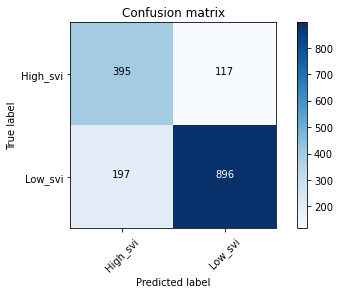

In [19]:
plot_cf_matrix(y_real, y_predict)

In [20]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [21]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 71.03it/s]


In [22]:
auc(fpr, tpr)

0.8794262494281794

In [23]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

Text(0.5, 1.0, 'ROC curve')

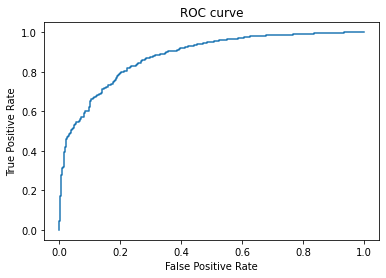

In [24]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [136]:
model_names = {1: 'Simple LSTM',
               2: 'Stacked LSTM',
               3: 'Bidirectional LSTM',
               4: 'CNN',
               5: 'CNN LSTM',
               6: 'LSTM Autoencoder',
               7: 'Deep CNN',
               8: 'GRU',
               9: 'GRU CNN'}

def plot_graphs_metrics(model, results_list, steps_in, steps_out):
    model_name = model_names[model]
    
    #this block of code is because some models (like 6) require steps_in start at 3 instead of 1
    shift_vals = {1: 1,
                  3: 1,
                  6: 3,
                  9: 2}
    shift_val = shift_vals[model]
    
    #plot graph of a metric result for all n_step_in and n_step_out values
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(4):
        for i in range(steps_in-shift_val):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
            plt.plot(x, y, label=f'n_steps_in={i+shift_val}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel(label[z])
        plt.title(model_name + ", 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
        plt.savefig(f"figures/{model_name} {label[z]}.png", bbox_inches="tight")
        plt.close()    
    
    #plot graph of all metric results for a n_step_in value
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(steps_in-shift_val):
        for i in range(4):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
            plt.plot(x, y, label=label[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel('Metric value')
        plt.title(f"{model_name}, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+shift_val} ")
        plt.savefig(f"figures/{model_name} n_steps_in={z+shift_val}.png", bbox_inches="tight")
        plt.close()

In [137]:
#Model type 1
def train_SIMPLE_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            model = Sequential()
            model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

###Just need to fill out the three functions for below. All other infrastructure is handled.###

#Model type 3
def train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            model = Sequential()
            model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(20, activation='relu')))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 6 - having lots of trouble with this one
#For some reason we need steps_in to be at least 3 for this one
#This probably has to do with the pooling, Convolution, or Dropout layers
def train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(3, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            model = Sequential()
            model.add(Conv1D(filters=128, 
                             kernel_size=2, 
                             activation='relu', 
                             name='extractor', 
                             input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dropout(0.3))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
            model.add(RepeatVector(10))
            model.add(Bidirectional(LSTM(50, activation='relu')))
            model.add(Dense(1))

            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

def train_GRU_CNN_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(2, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)            
            
            inp_seq = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
            x = Bidirectional(GRU(100, return_sequences=True))(inp_seq)
            x = AveragePooling1D(2)(x)
            x = Conv1D(100, 3, activation='relu', padding='same',
                       name='extractor')(x)
            x = Flatten()(x)
            x = Dense(16, activation='relu')(x)
            x = Dropout(0.5)(x)

            out = Dense(1, activation="sigmoid")(x)

            model = Model(inp_seq, out)

            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

In [139]:
#Code to run models
list_of_result_lists = {}
models_list = [1]

epochs = 10
steps_in = 6
steps_out = 10


steps_in += 1
steps_out += 1

#will soon add a resample parameter to each model
#(default to None if no resample, otherwise uses the desired sampler)
#or use some other system for incorporating resample
for m in models_list:
    if m == 1:
        results_list = train_SIMPLE_LSTM_model(epochs, steps_in, steps_out)
    elif m == 3:
        results_list = train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out)
    elif m == 6:
        results_list = train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out)
    elif m == 9:
        results_list = train_GRU_CNN_model(epochs, steps_in, steps_out)
    
    list_of_result_lists[m] = results_list
    plot_graphs_metrics(m, results_list, steps_in, steps_out)

100%|██████████| 1/1 [00:00<00:00, 516.03it/s]


Epoch 1/10
12854/12854 [==============================] - 6s 443us/step - loss: 0.6463
Epoch 2/10
12854/12854 [==============================] - 4s 291us/step - loss: 0.6051
Epoch 3/10
12854/12854 [==============================] - 4s 276us/step - loss: 0.5674
Epoch 4/10
12854/12854 [==============================] - 4s 278us/step - loss: 0.5241
Epoch 5/10
12854/12854 [==============================] - 4s 275us/step - loss: 0.4890
Epoch 6/10
12854/12854 [==============================] - 4s 279us/step - loss: 0.4637
Epoch 7/10
12854/12854 [==============================] - 4s 277us/step - loss: 0.4466
Epoch 8/10
12854/12854 [==============================] - 4s 276us/step - loss: 0.4359
Epoch 9/10
12854/12854 [==============================] - 4s 277us/step - loss: 0.4292
Epoch 10/10
12854/12854 [==============================] - 4s 277us/step - loss: 0.4251


100%|██████████| 1/1 [00:00<00:00, 892.79it/s]


Epoch 1/10
12851/12851 [==============================] - 5s 391us/step - loss: 0.6448
Epoch 2/10
12851/12851 [==============================] - 4s 346us/step - loss: 0.6127
Epoch 3/10
12851/12851 [==============================] - 4s 301us/step - loss: 0.5860
Epoch 4/10
12851/12851 [==============================] - 4s 303us/step - loss: 0.5545
Epoch 5/10
12851/12851 [==============================] - 4s 300us/step - loss: 0.5243
Epoch 6/10
12851/12851 [==============================] - 4s 302us/step - loss: 0.4979
Epoch 7/10
12851/12851 [==============================] - 4s 308us/step - loss: 0.4778
Epoch 8/10
12851/12851 [==============================] - 4s 346us/step - loss: 0.4639
Epoch 9/10
12851/12851 [==============================] - 4s 308us/step - loss: 0.4550
Epoch 10/10
12851/12851 [==============================] - 4s 291us/step - loss: 0.4497


100%|██████████| 1/1 [00:00<00:00, 169.78it/s]


Epoch 1/10
12848/12848 [==============================] - 5s 409us/step - loss: 0.6417
Epoch 2/10
12848/12848 [==============================] - 4s 286us/step - loss: 0.6107
Epoch 3/10
12848/12848 [==============================] - 4s 285us/step - loss: 0.5852
Epoch 4/10
12848/12848 [==============================] - 4s 287us/step - loss: 0.5577
Epoch 5/10
12848/12848 [==============================] - 4s 290us/step - loss: 0.5326
Epoch 6/10
12848/12848 [==============================] - 4s 299us/step - loss: 0.5113
Epoch 7/10
12848/12848 [==============================] - 4s 288us/step - loss: 0.4954
Epoch 8/10
12848/12848 [==============================] - 4s 290us/step - loss: 0.4839
Epoch 9/10
12848/12848 [==============================] - 4s 288us/step - loss: 0.4760
Epoch 10/10
12848/12848 [==============================] - 4s 290us/step - loss: 0.4706


100%|██████████| 1/1 [00:00<00:00, 742.88it/s]


Epoch 1/10
12844/12844 [==============================] - 5s 405us/step - loss: 0.6482
Epoch 2/10
12844/12844 [==============================] - 4s 297us/step - loss: 0.6122
Epoch 3/10
12844/12844 [==============================] - 4s 338us/step - loss: 0.5910
Epoch 4/10
12844/12844 [==============================] - 4s 331us/step - loss: 0.5638
Epoch 5/10
12844/12844 [==============================] - 4s 284us/step - loss: 0.5386
Epoch 6/10
12844/12844 [==============================] - 4s 278us/step - loss: 0.5187
Epoch 7/10
12844/12844 [==============================] - 4s 277us/step - loss: 0.5042
Epoch 8/10
12844/12844 [==============================] - 4s 276us/step - loss: 0.4938
Epoch 9/10
12844/12844 [==============================] - 4s 276us/step - loss: 0.4864
Epoch 10/10
12844/12844 [==============================] - 4s 296us/step - loss: 0.4816


100%|██████████| 1/1 [00:00<00:00, 731.73it/s]


Epoch 1/10
12841/12841 [==============================] - 5s 394us/step - loss: 0.6471
Epoch 2/10
12841/12841 [==============================] - 4s 280us/step - loss: 0.6150
Epoch 3/10
12841/12841 [==============================] - 4s 280us/step - loss: 0.5927
Epoch 4/10
12841/12841 [==============================] - 4s 276us/step - loss: 0.5644
Epoch 5/10
12841/12841 [==============================] - 4s 278us/step - loss: 0.5389
Epoch 6/10
12841/12841 [==============================] - 4s 275us/step - loss: 0.5194
Epoch 7/10
12841/12841 [==============================] - 4s 274us/step - loss: 0.5057
Epoch 8/10
12841/12841 [==============================] - 4s 274us/step - loss: 0.4962
Epoch 9/10
12841/12841 [==============================] - 4s 275us/step - loss: 0.4896
Epoch 10/10
12841/12841 [==============================] - 4s 275us/step - loss: 0.4854


100%|██████████| 1/1 [00:00<00:00, 779.47it/s]


Epoch 1/10
12838/12838 [==============================] - 5s 394us/step - loss: 0.6445
Epoch 2/10
12838/12838 [==============================] - 4s 278us/step - loss: 0.6146
Epoch 3/10
12838/12838 [==============================] - 4s 278us/step - loss: 0.5956
Epoch 4/10
12838/12838 [==============================] - 4s 279us/step - loss: 0.5735
Epoch 5/10
12838/12838 [==============================] - 4s 279us/step - loss: 0.5525
Epoch 6/10
12838/12838 [==============================] - 4s 304us/step - loss: 0.5350
Epoch 7/10
12838/12838 [==============================] - 4s 278us/step - loss: 0.5211
Epoch 8/10
12838/12838 [==============================] - 4s 281us/step - loss: 0.5109
Epoch 9/10
12838/12838 [==============================] - 4s 278us/step - loss: 0.5034
Epoch 10/10
12838/12838 [==============================] - 4s 278us/step - loss: 0.4981


100%|██████████| 1/1 [00:00<00:00, 827.28it/s]


Epoch 1/10
12835/12835 [==============================] - 5s 390us/step - loss: 0.6508
Epoch 2/10
12835/12835 [==============================] - 4s 277us/step - loss: 0.6139
Epoch 3/10
12835/12835 [==============================] - 4s 278us/step - loss: 0.5908
Epoch 4/10
12835/12835 [==============================] - 4s 278us/step - loss: 0.5666
Epoch 5/10
12835/12835 [==============================] - 4s 279us/step - loss: 0.5460
Epoch 6/10
12835/12835 [==============================] - 4s 278us/step - loss: 0.5306
Epoch 7/10
12835/12835 [==============================] - 4s 276us/step - loss: 0.5197
Epoch 8/10
12835/12835 [==============================] - 4s 277us/step - loss: 0.5121
Epoch 9/10
12835/12835 [==============================] - 4s 276us/step - loss: 0.5067
Epoch 10/10
12835/12835 [==============================] - 4s 278us/step - loss: 0.5028


100%|██████████| 1/1 [00:00<00:00, 685.34it/s]


Epoch 1/10
12832/12832 [==============================] - 5s 390us/step - loss: 0.6492
Epoch 2/10
12832/12832 [==============================] - 4s 276us/step - loss: 0.6202
Epoch 3/10
12832/12832 [==============================] - 4s 279us/step - loss: 0.6070
Epoch 4/10
12832/12832 [==============================] - 4s 278us/step - loss: 0.5888
Epoch 5/10
12832/12832 [==============================] - 4s 274us/step - loss: 0.5699
Epoch 6/10
12832/12832 [==============================] - 4s 285us/step - loss: 0.5532
Epoch 7/10
12832/12832 [==============================] - 4s 273us/step - loss: 0.5400
Epoch 8/10
12832/12832 [==============================] - 4s 276us/step - loss: 0.5302
Epoch 9/10
12832/12832 [==============================] - 4s 274us/step - loss: 0.5229
Epoch 10/10
12832/12832 [==============================] - 4s 274us/step - loss: 0.5174


100%|██████████| 1/1 [00:00<00:00, 863.03it/s]


Epoch 1/10
12828/12828 [==============================] - 5s 391us/step - loss: 0.6416
Epoch 2/10
12828/12828 [==============================] - 4s 274us/step - loss: 0.6168
Epoch 3/10
12828/12828 [==============================] - 4s 275us/step - loss: 0.6009
Epoch 4/10
12828/12828 [==============================] - 4s 275us/step - loss: 0.5822
Epoch 5/10
12828/12828 [==============================] - 4s 274us/step - loss: 0.5641
Epoch 6/10
12828/12828 [==============================] - 4s 278us/step - loss: 0.5494
Epoch 7/10
12828/12828 [==============================] - 4s 277us/step - loss: 0.5383
Epoch 8/10
12828/12828 [==============================] - 4s 278us/step - loss: 0.5297
Epoch 9/10
12828/12828 [==============================] - 4s 278us/step - loss: 0.5238
Epoch 10/10
12828/12828 [==============================] - 4s 282us/step - loss: 0.5196


100%|██████████| 1/1 [00:00<00:00, 708.74it/s]


Epoch 1/10
12825/12825 [==============================] - 5s 397us/step - loss: 0.6436
Epoch 2/10
12825/12825 [==============================] - 4s 278us/step - loss: 0.6146
Epoch 3/10
12825/12825 [==============================] - 4s 278us/step - loss: 0.6003
Epoch 4/10
12825/12825 [==============================] - 4s 277us/step - loss: 0.5831
Epoch 5/10
12825/12825 [==============================] - 4s 279us/step - loss: 0.5680
Epoch 6/10
12825/12825 [==============================] - 4s 280us/step - loss: 0.5557
Epoch 7/10
12825/12825 [==============================] - 4s 279us/step - loss: 0.5465
Epoch 8/10
12825/12825 [==============================] - 4s 277us/step - loss: 0.5398
Epoch 9/10
12825/12825 [==============================] - 4s 277us/step - loss: 0.5345
Epoch 10/10
12825/12825 [==============================] - 4s 278us/step - loss: 0.5306


100%|██████████| 2/2 [00:00<00:00, 665.13it/s]


Epoch 1/10
12851/12851 [==============================] - 6s 478us/step - loss: 0.6533
Epoch 2/10
12851/12851 [==============================] - 5s 362us/step - loss: 0.5981
Epoch 3/10
12851/12851 [==============================] - 5s 369us/step - loss: 0.5360
Epoch 4/10
12851/12851 [==============================] - 5s 363us/step - loss: 0.4749
Epoch 5/10
12851/12851 [==============================] - 5s 365us/step - loss: 0.4451
Epoch 6/10
12851/12851 [==============================] - 5s 371us/step - loss: 0.4327
Epoch 7/10
12851/12851 [==============================] - 5s 361us/step - loss: 0.4249
Epoch 8/10
12851/12851 [==============================] - 5s 362us/step - loss: 0.4214
Epoch 9/10
12851/12851 [==============================] - 5s 371us/step - loss: 0.4186
Epoch 10/10
12851/12851 [==============================] - 5s 368us/step - loss: 0.4161


100%|██████████| 2/2 [00:00<00:00, 655.31it/s]


Epoch 1/10
12848/12848 [==============================] - 6s 472us/step - loss: 0.6459
Epoch 2/10
12848/12848 [==============================] - 5s 361us/step - loss: 0.5999
Epoch 3/10
12848/12848 [==============================] - 5s 391us/step - loss: 0.5481
Epoch 4/10
12848/12848 [==============================] - 5s 395us/step - loss: 0.4984
Epoch 5/10
12848/12848 [==============================] - 5s 394us/step - loss: 0.4716
Epoch 6/10
12848/12848 [==============================] - 5s 392us/step - loss: 0.4569
Epoch 7/10
12848/12848 [==============================] - 5s 400us/step - loss: 0.4524
Epoch 8/10
12848/12848 [==============================] - 5s 396us/step - loss: 0.4467
Epoch 9/10
12848/12848 [==============================] - 5s 395us/step - loss: 0.4433
Epoch 10/10
12848/12848 [==============================] - 5s 397us/step - loss: 0.4415


100%|██████████| 2/2 [00:00<00:00, 677.98it/s]


Epoch 1/10
12844/12844 [==============================] - 7s 524us/step - loss: 0.6408
Epoch 2/10
12844/12844 [==============================] - 5s 402us/step - loss: 0.5708
Epoch 3/10
12844/12844 [==============================] - 5s 408us/step - loss: 0.5042
Epoch 4/10
12844/12844 [==============================] - 5s 427us/step - loss: 0.4723
Epoch 5/10
12844/12844 [==============================] - 5s 398us/step - loss: 0.4621
Epoch 6/10
12844/12844 [==============================] - 5s 398us/step - loss: 0.4545
Epoch 7/10
12844/12844 [==============================] - 5s 396us/step - loss: 0.4515
Epoch 8/10
12844/12844 [==============================] - 5s 401us/step - loss: 0.4524
Epoch 9/10
12844/12844 [==============================] - 5s 403us/step - loss: 0.4500
Epoch 10/10
12844/12844 [==============================] - 5s 408us/step - loss: 0.4480


100%|██████████| 2/2 [00:00<00:00, 650.63it/s]


Epoch 1/10
12841/12841 [==============================] - 7s 522us/step - loss: 0.6383
Epoch 2/10
12841/12841 [==============================] - 5s 392us/step - loss: 0.5954
Epoch 3/10
12841/12841 [==============================] - 5s 393us/step - loss: 0.5440
Epoch 4/10
12841/12841 [==============================] - 5s 402us/step - loss: 0.4978
Epoch 5/10
12841/12841 [==============================] - 5s 405us/step - loss: 0.4758
Epoch 6/10
12841/12841 [==============================] - 5s 393us/step - loss: 0.4665
Epoch 7/10
12841/12841 [==============================] - 5s 404us/step - loss: 0.4619
Epoch 8/10
12841/12841 [==============================] - 5s 396us/step - loss: 0.4597
Epoch 9/10
12841/12841 [==============================] - 5s 395us/step - loss: 0.4577
Epoch 10/10
12841/12841 [==============================] - 5s 404us/step - loss: 0.4570


100%|██████████| 2/2 [00:00<00:00, 665.97it/s]


Epoch 1/10
12838/12838 [==============================] - 7s 519us/step - loss: 0.6312
Epoch 2/10
12838/12838 [==============================] - 5s 402us/step - loss: 0.5791
Epoch 3/10
12838/12838 [==============================] - 5s 402us/step - loss: 0.5311
Epoch 4/10
12838/12838 [==============================] - 5s 402us/step - loss: 0.4979
Epoch 5/10
12838/12838 [==============================] - 5s 398us/step - loss: 0.4819
Epoch 6/10
12838/12838 [==============================] - 5s 398us/step - loss: 0.4747
Epoch 7/10
12838/12838 [==============================] - 5s 397us/step - loss: 0.4721
Epoch 8/10
12838/12838 [==============================] - 5s 365us/step - loss: 0.4691
Epoch 9/10
12838/12838 [==============================] - 5s 369us/step - loss: 0.4672
Epoch 10/10
12838/12838 [==============================] - 5s 364us/step - loss: 0.4671


100%|██████████| 2/2 [00:00<00:00, 675.63it/s]


Epoch 1/10
12835/12835 [==============================] - 8s 608us/step - loss: 0.6402
Epoch 2/10
12835/12835 [==============================] - 5s 362us/step - loss: 0.6039
Epoch 3/10
12835/12835 [==============================] - 5s 364us/step - loss: 0.5630
Epoch 4/10
12835/12835 [==============================] - 5s 360us/step - loss: 0.5281
Epoch 5/10
12835/12835 [==============================] - 5s 362us/step - loss: 0.5050
Epoch 6/10
12835/12835 [==============================] - 5s 362us/step - loss: 0.4929
Epoch 7/10
12835/12835 [==============================] - 5s 367us/step - loss: 0.4857
Epoch 8/10
12835/12835 [==============================] - 5s 367us/step - loss: 0.4847
Epoch 9/10
12835/12835 [==============================] - 5s 362us/step - loss: 0.4818
Epoch 10/10
12835/12835 [==============================] - 5s 361us/step - loss: 0.4789


100%|██████████| 2/2 [00:00<00:00, 620.92it/s]


Epoch 1/10
12832/12832 [==============================] - 6s 476us/step - loss: 0.6430
Epoch 2/10
12832/12832 [==============================] - 5s 414us/step - loss: 0.5963
Epoch 3/10
12832/12832 [==============================] - 5s 370us/step - loss: 0.5585
Epoch 4/10
12832/12832 [==============================] - 5s 374us/step - loss: 0.5304
Epoch 5/10
12832/12832 [==============================] - 5s 371us/step - loss: 0.5133
Epoch 6/10
12832/12832 [==============================] - 5s 365us/step - loss: 0.5039
Epoch 7/10
12832/12832 [==============================] - 5s 362us/step - loss: 0.4973
Epoch 8/10
12832/12832 [==============================] - 5s 363us/step - loss: 0.4954
Epoch 9/10
12832/12832 [==============================] - 5s 372us/step - loss: 0.4911
Epoch 10/10
12832/12832 [==============================] - 5s 363us/step - loss: 0.4900


100%|██████████| 2/2 [00:00<00:00, 668.41it/s]


Epoch 1/10
12828/12828 [==============================] - 7s 565us/step - loss: 0.6351
Epoch 2/10
12828/12828 [==============================] - 6s 486us/step - loss: 0.6063
Epoch 3/10
12828/12828 [==============================] - 5s 413us/step - loss: 0.5750
Epoch 4/10
12828/12828 [==============================] - 7s 508us/step - loss: 0.5456
Epoch 5/10
12828/12828 [==============================] - 5s 369us/step - loss: 0.5239
Epoch 6/10
12828/12828 [==============================] - 5s 372us/step - loss: 0.5118
Epoch 7/10
12828/12828 [==============================] - 5s 378us/step - loss: 0.5043
Epoch 8/10
12828/12828 [==============================] - 5s 383us/step - loss: 0.5025
Epoch 9/10
12828/12828 [==============================] - 7s 564us/step - loss: 0.4988
Epoch 10/10
12828/12828 [==============================] - 5s 379us/step - loss: 0.4968


100%|██████████| 2/2 [00:00<00:00, 633.34it/s]


Epoch 1/10
12825/12825 [==============================] - 9s 689us/step - loss: 0.6356
Epoch 2/10
12825/12825 [==============================] - 5s 426us/step - loss: 0.5969
Epoch 3/10
12825/12825 [==============================] - 5s 360us/step - loss: 0.5618
Epoch 4/10
12825/12825 [==============================] - 5s 364us/step - loss: 0.5376
Epoch 5/10
12825/12825 [==============================] - 5s 363us/step - loss: 0.5247
Epoch 6/10
12825/12825 [==============================] - 5s 384us/step - loss: 0.5172
Epoch 7/10
12825/12825 [==============================] - 6s 451us/step - loss: 0.5136
Epoch 8/10
12825/12825 [==============================] - 5s 404us/step - loss: 0.5108
Epoch 9/10
12825/12825 [==============================] - 6s 499us/step - loss: 0.5098
Epoch 10/10
12825/12825 [==============================] - 6s 468us/step - loss: 0.5076


100%|██████████| 2/2 [00:00<00:00, 516.13it/s]


Epoch 1/10
12822/12822 [==============================] - 6s 500us/step - loss: 0.6426
Epoch 2/10
12822/12822 [==============================] - 5s 370us/step - loss: 0.6136
Epoch 3/10
12822/12822 [==============================] - 5s 367us/step - loss: 0.5905
Epoch 4/10
12822/12822 [==============================] - 5s 362us/step - loss: 0.5654
Epoch 5/10
12822/12822 [==============================] - 5s 363us/step - loss: 0.5464
Epoch 6/10
12822/12822 [==============================] - 5s 365us/step - loss: 0.5356
Epoch 7/10
12822/12822 [==============================] - 5s 374us/step - loss: 0.5274
Epoch 8/10
12822/12822 [==============================] - 5s 370us/step - loss: 0.5236
Epoch 9/10
12822/12822 [==============================] - 5s 368us/step - loss: 0.5216
Epoch 10/10
12822/12822 [==============================] - 5s 363us/step - loss: 0.5195


100%|██████████| 3/3 [00:00<00:00, 710.90it/s]


Epoch 1/10
12848/12848 [==============================] - 7s 562us/step - loss: 0.6227
Epoch 2/10
12848/12848 [==============================] - 6s 446us/step - loss: 0.5337
Epoch 3/10
12848/12848 [==============================] - 6s 447us/step - loss: 0.4608
Epoch 4/10
12848/12848 [==============================] - 6s 453us/step - loss: 0.4390
Epoch 5/10
12848/12848 [==============================] - 6s 448us/step - loss: 0.4301
Epoch 6/10
12848/12848 [==============================] - 6s 444us/step - loss: 0.4252
Epoch 7/10
12848/12848 [==============================] - 6s 448us/step - loss: 0.4193
Epoch 8/10
12848/12848 [==============================] - 6s 462us/step - loss: 0.4162
Epoch 9/10
12848/12848 [==============================] - 6s 486us/step - loss: 0.4116
Epoch 10/10
12848/12848 [==============================] - 6s 489us/step - loss: 0.4120


100%|██████████| 3/3 [00:00<00:00, 591.25it/s]


Epoch 1/10
12844/12844 [==============================] - 8s 593us/step - loss: 0.6250
Epoch 2/10
12844/12844 [==============================] - 6s 448us/step - loss: 0.5464
Epoch 3/10
12844/12844 [==============================] - 6s 447us/step - loss: 0.4748
Epoch 4/10
12844/12844 [==============================] - 6s 449us/step - loss: 0.4537
Epoch 5/10
12844/12844 [==============================] - 6s 463us/step - loss: 0.4438
Epoch 6/10
12844/12844 [==============================] - 6s 455us/step - loss: 0.4399
Epoch 7/10
12844/12844 [==============================] - 6s 447us/step - loss: 0.4363
Epoch 8/10
12844/12844 [==============================] - 6s 455us/step - loss: 0.4331
Epoch 9/10
12844/12844 [==============================] - 6s 447us/step - loss: 0.4302
Epoch 10/10
12844/12844 [==============================] - 6s 463us/step - loss: 0.4297


100%|██████████| 3/3 [00:00<00:00, 705.08it/s]


Epoch 1/10
12841/12841 [==============================] - 7s 562us/step - loss: 0.6321
Epoch 2/10
12841/12841 [==============================] - 6s 452us/step - loss: 0.5687
Epoch 3/10
12841/12841 [==============================] - 6s 449us/step - loss: 0.5014
Epoch 4/10
12841/12841 [==============================] - 6s 460us/step - loss: 0.4727
Epoch 5/10
12841/12841 [==============================] - 6s 456us/step - loss: 0.4647
Epoch 6/10
12841/12841 [==============================] - 6s 455us/step - loss: 0.4601
Epoch 7/10
12841/12841 [==============================] - 6s 447us/step - loss: 0.4530
Epoch 8/10
12841/12841 [==============================] - 6s 448us/step - loss: 0.4498
Epoch 9/10
12841/12841 [==============================] - 6s 446us/step - loss: 0.4459
Epoch 10/10
12841/12841 [==============================] - 6s 461us/step - loss: 0.4428


100%|██████████| 3/3 [00:00<00:00, 742.97it/s]


Epoch 1/10
12838/12838 [==============================] - 8s 592us/step - loss: 0.6295
Epoch 2/10
12838/12838 [==============================] - 6s 465us/step - loss: 0.5421
Epoch 3/10
12838/12838 [==============================] - 6s 450us/step - loss: 0.4893
Epoch 4/10
12838/12838 [==============================] - 6s 448us/step - loss: 0.4756
Epoch 5/10
12838/12838 [==============================] - 6s 460us/step - loss: 0.4693
Epoch 6/10
12838/12838 [==============================] - 6s 443us/step - loss: 0.4642
Epoch 7/10
12838/12838 [==============================] - 6s 442us/step - loss: 0.4626
Epoch 8/10
12838/12838 [==============================] - 6s 447us/step - loss: 0.4601
Epoch 9/10
12838/12838 [==============================] - 6s 463us/step - loss: 0.4567
Epoch 10/10
12838/12838 [==============================] - 6s 446us/step - loss: 0.4564


100%|██████████| 3/3 [00:00<00:00, 423.14it/s]


Epoch 1/10
12835/12835 [==============================] - 7s 565us/step - loss: 0.6283
Epoch 2/10
12835/12835 [==============================] - 6s 447us/step - loss: 0.5725
Epoch 3/10
12835/12835 [==============================] - 6s 453us/step - loss: 0.5176
Epoch 4/10
12835/12835 [==============================] - 6s 464us/step - loss: 0.4939
Epoch 5/10
12835/12835 [==============================] - 6s 463us/step - loss: 0.4844
Epoch 6/10
12835/12835 [==============================] - 7s 554us/step - loss: 0.4774
Epoch 7/10
12835/12835 [==============================] - 6s 489us/step - loss: 0.4724
Epoch 8/10
12835/12835 [==============================] - 6s 470us/step - loss: 0.4707
Epoch 9/10
12835/12835 [==============================] - 7s 568us/step - loss: 0.4684
Epoch 10/10
12835/12835 [==============================] - 6s 500us/step - loss: 0.4672


100%|██████████| 3/3 [00:00<00:00, 212.62it/s]


Epoch 1/10
12832/12832 [==============================] - 8s 591us/step - loss: 0.6270
Epoch 2/10
12832/12832 [==============================] - 6s 472us/step - loss: 0.5840
Epoch 3/10
12832/12832 [==============================] - 6s 460us/step - loss: 0.5337
Epoch 4/10
12832/12832 [==============================] - 6s 494us/step - loss: 0.5035
Epoch 5/10
12832/12832 [==============================] - 6s 452us/step - loss: 0.4920
Epoch 6/10
12832/12832 [==============================] - 6s 449us/step - loss: 0.4861
Epoch 7/10
12832/12832 [==============================] - 6s 467us/step - loss: 0.4835
Epoch 8/10
12832/12832 [==============================] - 6s 447us/step - loss: 0.4810
Epoch 9/10
12832/12832 [==============================] - 6s 453us/step - loss: 0.4790
Epoch 10/10
12832/12832 [==============================] - 6s 448us/step - loss: 0.4763


100%|██████████| 3/3 [00:00<00:00, 744.95it/s]


Epoch 1/10
12828/12828 [==============================] - 8s 647us/step - loss: 0.6475
Epoch 2/10
12828/12828 [==============================] - 8s 636us/step - loss: 0.5856
Epoch 3/10
12828/12828 [==============================] - 8s 589us/step - loss: 0.5286
Epoch 4/10
12828/12828 [==============================] - 6s 486us/step - loss: 0.5070
Epoch 5/10
12828/12828 [==============================] - 7s 573us/step - loss: 0.4986
Epoch 6/10
12828/12828 [==============================] - 7s 528us/step - loss: 0.4952
Epoch 7/10
12828/12828 [==============================] - 6s 492us/step - loss: 0.4903
Epoch 8/10
12828/12828 [==============================] - 6s 483us/step - loss: 0.4897
Epoch 9/10
12828/12828 [==============================] - 6s 490us/step - loss: 0.4855
Epoch 10/10
12828/12828 [==============================] - 6s 491us/step - loss: 0.4851


100%|██████████| 3/3 [00:00<00:00, 756.23it/s]


Epoch 1/10
12825/12825 [==============================] - 8s 651us/step - loss: 0.6333
Epoch 2/10
12825/12825 [==============================] - 7s 516us/step - loss: 0.5860
Epoch 3/10
12825/12825 [==============================] - 6s 480us/step - loss: 0.5436
Epoch 4/10
12825/12825 [==============================] - 7s 544us/step - loss: 0.5225
Epoch 5/10
12825/12825 [==============================] - 6s 501us/step - loss: 0.5139
Epoch 6/10
12825/12825 [==============================] - 6s 498us/step - loss: 0.5094
Epoch 7/10
12825/12825 [==============================] - 6s 454us/step - loss: 0.5067
Epoch 8/10
12825/12825 [==============================] - 6s 447us/step - loss: 0.5038
Epoch 9/10
12825/12825 [==============================] - 6s 447us/step - loss: 0.5015
Epoch 10/10
12825/12825 [==============================] - 6s 448us/step - loss: 0.4994


100%|██████████| 3/3 [00:00<00:00, 695.46it/s]


Epoch 1/10
12822/12822 [==============================] - 7s 574us/step - loss: 0.6310
Epoch 2/10
12822/12822 [==============================] - 6s 450us/step - loss: 0.5680
Epoch 3/10
12822/12822 [==============================] - 6s 468us/step - loss: 0.5381
Epoch 4/10
12822/12822 [==============================] - 6s 460us/step - loss: 0.5263
Epoch 5/10
12822/12822 [==============================] - 6s 453us/step - loss: 0.5202
Epoch 6/10
12822/12822 [==============================] - 6s 450us/step - loss: 0.5160
Epoch 7/10
12822/12822 [==============================] - 6s 453us/step - loss: 0.5138
Epoch 8/10
12822/12822 [==============================] - 6s 450us/step - loss: 0.5099
Epoch 9/10
12822/12822 [==============================] - 6s 469us/step - loss: 0.5096
Epoch 10/10
12822/12822 [==============================] - 6s 497us/step - loss: 0.5069


100%|██████████| 3/3 [00:00<00:00, 459.72it/s]


Epoch 1/10
12819/12819 [==============================] - 8s 637us/step - loss: 0.6259
Epoch 2/10
12819/12819 [==============================] - 6s 468us/step - loss: 0.5818
Epoch 3/10
12819/12819 [==============================] - 6s 494us/step - loss: 0.5515
Epoch 4/10
12819/12819 [==============================] - 6s 448us/step - loss: 0.5339
Epoch 5/10
12819/12819 [==============================] - 6s 464us/step - loss: 0.5235
Epoch 6/10
12819/12819 [==============================] - 6s 469us/step - loss: 0.5189
Epoch 7/10
12819/12819 [==============================] - 7s 517us/step - loss: 0.5179
Epoch 8/10
12819/12819 [==============================] - 6s 474us/step - loss: 0.5163
Epoch 9/10
12819/12819 [==============================] - 7s 557us/step - loss: 0.5122
Epoch 10/10
12819/12819 [==============================] - 6s 471us/step - loss: 0.5106


100%|██████████| 4/4 [00:00<00:00, 723.47it/s]


Epoch 1/10
12844/12844 [==============================] - 8s 650us/step - loss: 0.6045
Epoch 2/10
12844/12844 [==============================] - 7s 568us/step - loss: 0.4864
Epoch 3/10
12844/12844 [==============================] - 7s 562us/step - loss: 0.4418
Epoch 4/10
12844/12844 [==============================] - 7s 528us/step - loss: 0.4304
Epoch 5/10
12844/12844 [==============================] - 7s 524us/step - loss: 0.4256
Epoch 6/10
12844/12844 [==============================] - 7s 528us/step - loss: 0.4214
Epoch 7/10
12844/12844 [==============================] - 7s 533us/step - loss: 0.4166
Epoch 8/10
12844/12844 [==============================] - 7s 535us/step - loss: 0.4136
Epoch 9/10
12844/12844 [==============================] - 7s 527us/step - loss: 0.4128
Epoch 10/10
12844/12844 [==============================] - 7s 551us/step - loss: 0.4089


100%|██████████| 4/4 [00:00<00:00, 684.67it/s]


Epoch 1/10
12841/12841 [==============================] - 8s 649us/step - loss: 0.6157
Epoch 2/10
12841/12841 [==============================] - 7s 548us/step - loss: 0.5083
Epoch 3/10
12841/12841 [==============================] - 7s 584us/step - loss: 0.4586
Epoch 4/10
12841/12841 [==============================] - 7s 538us/step - loss: 0.4474
Epoch 5/10
12841/12841 [==============================] - 7s 560us/step - loss: 0.4401
Epoch 6/10
12841/12841 [==============================] - 7s 542us/step - loss: 0.4347
Epoch 7/10
12841/12841 [==============================] - 8s 606us/step - loss: 0.4343
Epoch 8/10
12841/12841 [==============================] - 7s 572us/step - loss: 0.4284
Epoch 9/10
12841/12841 [==============================] - 7s 575us/step - loss: 0.4252
Epoch 10/10
12841/12841 [==============================] - 7s 535us/step - loss: 0.4235


100%|██████████| 4/4 [00:00<00:00, 707.72it/s]


Epoch 1/10
12838/12838 [==============================] - 8s 657us/step - loss: 0.6292
Epoch 2/10
12838/12838 [==============================] - 8s 585us/step - loss: 0.5298
Epoch 3/10
12838/12838 [==============================] - 7s 554us/step - loss: 0.4727
Epoch 4/10
12838/12838 [==============================] - 8s 590us/step - loss: 0.4623
Epoch 5/10
12838/12838 [==============================] - 8s 585us/step - loss: 0.4545
Epoch 6/10
12838/12838 [==============================] - 8s 601us/step - loss: 0.4498
Epoch 7/10
12838/12838 [==============================] - 7s 536us/step - loss: 0.4472
Epoch 8/10
12838/12838 [==============================] - 7s 542us/step - loss: 0.4445
Epoch 9/10
12838/12838 [==============================] - 7s 545us/step - loss: 0.4431
Epoch 10/10
12838/12838 [==============================] - 7s 545us/step - loss: 0.4392


100%|██████████| 4/4 [00:00<00:00, 709.10it/s]


Epoch 1/10
12835/12835 [==============================] - 9s 702us/step - loss: 0.6225
Epoch 2/10
12835/12835 [==============================] - 7s 576us/step - loss: 0.5595
Epoch 3/10
12835/12835 [==============================] - 9s 672us/step - loss: 0.4969
Epoch 4/10
12835/12835 [==============================] - 9s 679us/step - loss: 0.4776
Epoch 5/10
12835/12835 [==============================] - 9s 721us/step - loss: 0.4704
Epoch 6/10
12835/12835 [==============================] - 7s 565us/step - loss: 0.4670
Epoch 7/10
12835/12835 [==============================] - 7s 538us/step - loss: 0.4636
Epoch 8/10
12835/12835 [==============================] - 7s 532us/step - loss: 0.4580
Epoch 9/10
12835/12835 [==============================] - 7s 529us/step - loss: 0.4569
Epoch 10/10
12835/12835 [==============================] - 7s 553us/step - loss: 0.4555


100%|██████████| 4/4 [00:00<00:00, 595.76it/s]


Epoch 1/10
12832/12832 [==============================] - 9s 686us/step - loss: 0.6322
Epoch 2/10
12832/12832 [==============================] - 7s 548us/step - loss: 0.5716
Epoch 3/10
12832/12832 [==============================] - 7s 533us/step - loss: 0.5146
Epoch 4/10
12832/12832 [==============================] - 7s 543us/step - loss: 0.4910
Epoch 5/10
12832/12832 [==============================] - 7s 550us/step - loss: 0.4834
Epoch 6/10
12832/12832 [==============================] - 7s 546us/step - loss: 0.4806
Epoch 7/10
12832/12832 [==============================] - 7s 545us/step - loss: 0.4744
Epoch 8/10
12832/12832 [==============================] - 7s 556us/step - loss: 0.4713
Epoch 9/10
12832/12832 [==============================] - 7s 548us/step - loss: 0.4676
Epoch 10/10
12832/12832 [==============================] - 7s 548us/step - loss: 0.4634


100%|██████████| 4/4 [00:00<00:00, 711.74it/s]


Epoch 1/10
12828/12828 [==============================] - 9s 688us/step - loss: 0.6235
Epoch 2/10
12828/12828 [==============================] - 7s 553us/step - loss: 0.5468
Epoch 3/10
12828/12828 [==============================] - 7s 561us/step - loss: 0.5042
Epoch 4/10
12828/12828 [==============================] - 8s 588us/step - loss: 0.4916
Epoch 5/10
12828/12828 [==============================] - 7s 547us/step - loss: 0.4867
Epoch 6/10
12828/12828 [==============================] - 7s 548us/step - loss: 0.4826
Epoch 7/10
12828/12828 [==============================] - 7s 548us/step - loss: 0.4816
Epoch 8/10
12828/12828 [==============================] - 7s 569us/step - loss: 0.4772
Epoch 9/10
12828/12828 [==============================] - 8s 604us/step - loss: 0.4749
Epoch 10/10
12828/12828 [==============================] - 8s 606us/step - loss: 0.4739


100%|██████████| 4/4 [00:00<00:00, 595.49it/s]


Epoch 1/10
12825/12825 [==============================] - 9s 740us/step - loss: 0.6372
Epoch 2/10
12825/12825 [==============================] - 8s 588us/step - loss: 0.5874
Epoch 3/10
12825/12825 [==============================] - 8s 651us/step - loss: 0.5404
Epoch 4/10
12825/12825 [==============================] - 8s 602us/step - loss: 0.5181
Epoch 5/10
12825/12825 [==============================] - 8s 590us/step - loss: 0.5061
Epoch 6/10
12825/12825 [==============================] - 8s 593us/step - loss: 0.5008
Epoch 7/10
12825/12825 [==============================] - 8s 602us/step - loss: 0.4976
Epoch 8/10
12825/12825 [==============================] - 8s 585us/step - loss: 0.4942
Epoch 9/10
12825/12825 [==============================] - 8s 594us/step - loss: 0.4911
Epoch 10/10
12825/12825 [==============================] - 7s 578us/step - loss: 0.4892


100%|██████████| 4/4 [00:00<00:00, 673.19it/s]


Epoch 1/10
12822/12822 [==============================] - 8s 662us/step - loss: 0.6263
Epoch 2/10
12822/12822 [==============================] - 7s 529us/step - loss: 0.5704
Epoch 3/10
12822/12822 [==============================] - 7s 538us/step - loss: 0.5301
Epoch 4/10
12822/12822 [==============================] - 7s 577us/step - loss: 0.5191
Epoch 5/10
12822/12822 [==============================] - 7s 550us/step - loss: 0.5112
Epoch 6/10
12822/12822 [==============================] - 7s 560us/step - loss: 0.5076
Epoch 7/10
12822/12822 [==============================] - 7s 551us/step - loss: 0.5068
Epoch 8/10
12822/12822 [==============================] - 7s 573us/step - loss: 0.5051
Epoch 9/10
12822/12822 [==============================] - 7s 547us/step - loss: 0.5000
Epoch 10/10
12822/12822 [==============================] - 7s 569us/step - loss: 0.4974


100%|██████████| 4/4 [00:00<00:00, 711.62it/s]


Epoch 1/10
12819/12819 [==============================] - 8s 644us/step - loss: 0.6341
Epoch 2/10
12819/12819 [==============================] - 7s 527us/step - loss: 0.5836
Epoch 3/10
12819/12819 [==============================] - 7s 564us/step - loss: 0.5429
Epoch 4/10
12819/12819 [==============================] - 7s 562us/step - loss: 0.5264
Epoch 5/10
12819/12819 [==============================] - 7s 568us/step - loss: 0.5204
Epoch 6/10
12819/12819 [==============================] - 7s 564us/step - loss: 0.5166
Epoch 7/10
12819/12819 [==============================] - 7s 564us/step - loss: 0.5139
Epoch 8/10
12819/12819 [==============================] - 7s 556us/step - loss: 0.5117
Epoch 9/10
12819/12819 [==============================] - 7s 540us/step - loss: 0.5077
Epoch 10/10
12819/12819 [==============================] - 7s 547us/step - loss: 0.5067


100%|██████████| 4/4 [00:00<00:00, 694.54it/s]


Epoch 1/10
12816/12816 [==============================] - 9s 712us/step - loss: 0.6312
Epoch 2/10
12816/12816 [==============================] - 8s 601us/step - loss: 0.5861
Epoch 3/10
12816/12816 [==============================] - 8s 594us/step - loss: 0.5492
Epoch 4/10
12816/12816 [==============================] - 8s 597us/step - loss: 0.5344
Epoch 5/10
12816/12816 [==============================] - 8s 619us/step - loss: 0.5298
Epoch 6/10
12816/12816 [==============================] - 8s 614us/step - loss: 0.5230
Epoch 7/10
12816/12816 [==============================] - 8s 600us/step - loss: 0.5222
Epoch 8/10
12816/12816 [==============================] - 8s 597us/step - loss: 0.5188
Epoch 9/10
12816/12816 [==============================] - 8s 591us/step - loss: 0.5180
Epoch 10/10
12816/12816 [==============================] - 7s 568us/step - loss: 0.5155


100%|██████████| 5/5 [00:00<00:00, 640.21it/s]


Epoch 1/10
12841/12841 [==============================] - 10s 769us/step - loss: 0.6224
Epoch 2/10
12841/12841 [==============================] - 8s 646us/step - loss: 0.4958
Epoch 3/10
12841/12841 [==============================] - 9s 674us/step - loss: 0.4557
Epoch 4/10
12841/12841 [==============================] - 8s 659us/step - loss: 0.4466
Epoch 5/10
12841/12841 [==============================] - 8s 655us/step - loss: 0.4401
Epoch 6/10
12841/12841 [==============================] - 8s 656us/step - loss: 0.4316
Epoch 7/10
12841/12841 [==============================] - 11s 837us/step - loss: 0.4284
Epoch 8/10
12841/12841 [==============================] - 9s 695us/step - loss: 0.4225
Epoch 9/10
12841/12841 [==============================] - 10s 813us/step - loss: 0.4214
Epoch 10/10
12841/12841 [==============================] - 9s 698us/step - loss: 0.4121


100%|██████████| 5/5 [00:00<00:00, 528.16it/s]


Epoch 1/10
12838/12838 [==============================] - 12s 911us/step - loss: 0.6192
Epoch 2/10
12838/12838 [==============================] - 8s 653us/step - loss: 0.5088
Epoch 3/10
12838/12838 [==============================] - 8s 652us/step - loss: 0.4652
Epoch 4/10
12838/12838 [==============================] - 9s 683us/step - loss: 0.4620
Epoch 5/10
12838/12838 [==============================] - 8s 659us/step - loss: 0.4499
Epoch 6/10
12838/12838 [==============================] - 9s 669us/step - loss: 0.4457
Epoch 7/10
12838/12838 [==============================] - 9s 667us/step - loss: 0.4408
Epoch 8/10
12838/12838 [==============================] - 8s 658us/step - loss: 0.4355
Epoch 9/10
12838/12838 [==============================] - 9s 663us/step - loss: 0.4321
Epoch 10/10
12838/12838 [==============================] - 9s 686us/step - loss: 0.4296


100%|██████████| 5/5 [00:00<00:00, 669.25it/s]


Epoch 1/10
12835/12835 [==============================] - 10s 778us/step - loss: 0.6261
Epoch 2/10
12835/12835 [==============================] - 8s 617us/step - loss: 0.5310
Epoch 3/10
12835/12835 [==============================] - 10s 800us/step - loss: 0.4924
Epoch 4/10
12835/12835 [==============================] - 8s 650us/step - loss: 0.4756
Epoch 5/10
12835/12835 [==============================] - 9s 687us/step - loss: 0.4662
Epoch 6/10
12835/12835 [==============================] - 9s 680us/step - loss: 0.4602
Epoch 7/10
12835/12835 [==============================] - 10s 789us/step - loss: 0.4545
Epoch 8/10
12835/12835 [==============================] - 10s 807us/step - loss: 0.4534
Epoch 9/10
12835/12835 [==============================] - 10s 753us/step - loss: 0.4494
Epoch 10/10
12835/12835 [==============================] - 10s 793us/step - loss: 0.4458


100%|██████████| 5/5 [00:00<00:00, 653.58it/s]


Epoch 1/10
12832/12832 [==============================] - 10s 779us/step - loss: 0.6143
Epoch 2/10
12832/12832 [==============================] - 8s 657us/step - loss: 0.5074
Epoch 3/10
12832/12832 [==============================] - 9s 679us/step - loss: 0.4847
Epoch 4/10
12832/12832 [==============================] - 10s 794us/step - loss: 0.4744
Epoch 5/10
12832/12832 [==============================] - 10s 796us/step - loss: 0.4683
Epoch 6/10
12832/12832 [==============================] - 9s 739us/step - loss: 0.4629
Epoch 7/10
12832/12832 [==============================] - 10s 788us/step - loss: 0.4630
Epoch 8/10
12832/12832 [==============================] - 9s 731us/step - loss: 0.4570
Epoch 9/10
12832/12832 [==============================] - 9s 706us/step - loss: 0.4569
Epoch 10/10
12832/12832 [==============================] - 9s 739us/step - loss: 0.4547


100%|██████████| 5/5 [00:00<00:00, 522.10it/s]


Epoch 1/10
12828/12828 [==============================] - 10s 808us/step - loss: 0.6133
Epoch 2/10
12828/12828 [==============================] - 9s 721us/step - loss: 0.5227
Epoch 3/10
12828/12828 [==============================] - 9s 721us/step - loss: 0.4934
Epoch 4/10
12828/12828 [==============================] - 9s 708us/step - loss: 0.4864
Epoch 5/10
12828/12828 [==============================] - 9s 701us/step - loss: 0.4818
Epoch 6/10
12828/12828 [==============================] - 9s 702us/step - loss: 0.4758
Epoch 7/10
12828/12828 [==============================] - 9s 719us/step - loss: 0.4713
Epoch 8/10
12828/12828 [==============================] - 9s 731us/step - loss: 0.4695
Epoch 9/10
12828/12828 [==============================] - 10s 754us/step - loss: 0.4667
Epoch 10/10
12828/12828 [==============================] - 9s 698us/step - loss: 0.4637


100%|██████████| 5/5 [00:00<00:00, 559.29it/s]


Epoch 1/10
12825/12825 [==============================] - 12s 974us/step - loss: 0.6094
Epoch 2/10
12825/12825 [==============================] - 9s 700us/step - loss: 0.5290
Epoch 3/10
12825/12825 [==============================] - 9s 692us/step - loss: 0.5014
Epoch 4/10
12825/12825 [==============================] - 9s 717us/step - loss: 0.4912
Epoch 5/10
12825/12825 [==============================] - 10s 758us/step - loss: 0.4859
Epoch 6/10
12825/12825 [==============================] - 11s 830us/step - loss: 0.4830
Epoch 7/10
12825/12825 [==============================] - 10s 803us/step - loss: 0.4785
Epoch 8/10
12825/12825 [==============================] - 9s 682us/step - loss: 0.4772
Epoch 9/10
12825/12825 [==============================] - 9s 685us/step - loss: 0.4759
Epoch 10/10
12825/12825 [==============================] - 9s 682us/step - loss: 0.4741


100%|██████████| 5/5 [00:00<00:00, 577.44it/s]


Epoch 1/10
12822/12822 [==============================] - 10s 749us/step - loss: 0.6337
Epoch 2/10
12822/12822 [==============================] - 8s 658us/step - loss: 0.5511
Epoch 3/10
12822/12822 [==============================] - 9s 710us/step - loss: 0.5241
Epoch 4/10
12822/12822 [==============================] - 9s 738us/step - loss: 0.5175
Epoch 5/10
12822/12822 [==============================] - 10s 779us/step - loss: 0.5083
Epoch 6/10
12822/12822 [==============================] - 11s 829us/step - loss: 0.5040
Epoch 7/10
12822/12822 [==============================] - 9s 688us/step - loss: 0.5001
Epoch 8/10
12822/12822 [==============================] - 9s 665us/step - loss: 0.4963
Epoch 9/10
12822/12822 [==============================] - 9s 677us/step - loss: 0.4932
Epoch 10/10
12822/12822 [==============================] - 8s 651us/step - loss: 0.4918


100%|██████████| 5/5 [00:00<00:00, 680.16it/s]


Epoch 1/10
12819/12819 [==============================] - 10s 787us/step - loss: 0.6333
Epoch 2/10
12819/12819 [==============================] - 8s 643us/step - loss: 0.5480
Epoch 3/10
12819/12819 [==============================] - 9s 670us/step - loss: 0.5220
Epoch 4/10
12819/12819 [==============================] - 9s 685us/step - loss: 0.5139
Epoch 5/10
12819/12819 [==============================] - 9s 716us/step - loss: 0.5079
Epoch 6/10
12819/12819 [==============================] - 9s 694us/step - loss: 0.5052
Epoch 7/10
12819/12819 [==============================] - 9s 702us/step - loss: 0.5024
Epoch 8/10
12819/12819 [==============================] - 9s 709us/step - loss: 0.4999
Epoch 9/10
12819/12819 [==============================] - 9s 704us/step - loss: 0.4947
Epoch 10/10
12819/12819 [==============================] - 9s 679us/step - loss: 0.4942


100%|██████████| 5/5 [00:00<00:00, 591.43it/s]


Epoch 1/10
12816/12816 [==============================] - 10s 807us/step - loss: 0.6257
Epoch 2/10
12816/12816 [==============================] - 9s 708us/step - loss: 0.5721
Epoch 3/10
12816/12816 [==============================] - 9s 718us/step - loss: 0.5409
Epoch 4/10
12816/12816 [==============================] - 9s 670us/step - loss: 0.5312
Epoch 5/10
12816/12816 [==============================] - 10s 771us/step - loss: 0.5243
Epoch 6/10
12816/12816 [==============================] - 10s 793us/step - loss: 0.5224
Epoch 7/10
12816/12816 [==============================] - 10s 743us/step - loss: 0.5171
Epoch 8/10
12816/12816 [==============================] - 10s 780us/step - loss: 0.5147
Epoch 9/10
12816/12816 [==============================] - 9s 689us/step - loss: 0.5153
Epoch 10/10
12816/12816 [==============================] - 9s 669us/step - loss: 0.5106


100%|██████████| 5/5 [00:00<00:00, 663.05it/s]


Epoch 1/10
12812/12812 [==============================] - 9s 728us/step - loss: 0.6212
Epoch 2/10
12812/12812 [==============================] - 8s 607us/step - loss: 0.5618
Epoch 3/10
12812/12812 [==============================] - 10s 748us/step - loss: 0.5379
Epoch 4/10
12812/12812 [==============================] - 9s 730us/step - loss: 0.5294
Epoch 5/10
12812/12812 [==============================] - 9s 682us/step - loss: 0.5258
Epoch 6/10
12812/12812 [==============================] - 10s 788us/step - loss: 0.5210
Epoch 7/10
12812/12812 [==============================] - 9s 730us/step - loss: 0.5194
Epoch 8/10
12812/12812 [==============================] - 9s 736us/step - loss: 0.5175
Epoch 9/10
12812/12812 [==============================] - 10s 807us/step - loss: 0.5148
Epoch 10/10
12812/12812 [==============================] - 10s 758us/step - loss: 0.5124


100%|██████████| 6/6 [00:00<00:00, 387.67it/s]


Epoch 1/10
12838/12838 [==============================] - 12s 905us/step - loss: 0.6225
Epoch 2/10
12838/12838 [==============================] - 10s 772us/step - loss: 0.5146
Epoch 3/10
12838/12838 [==============================] - 10s 816us/step - loss: 0.4706
Epoch 4/10
12838/12838 [==============================] - 9s 695us/step - loss: 0.4546
Epoch 5/10
12838/12838 [==============================] - 9s 700us/step - loss: 0.4439
Epoch 6/10
12838/12838 [==============================] - 9s 724us/step - loss: 0.4392
Epoch 7/10
12838/12838 [==============================] - 10s 741us/step - loss: 0.4295
Epoch 8/10
12838/12838 [==============================] - 9s 738us/step - loss: 0.4281
Epoch 9/10
12838/12838 [==============================] - 9s 738us/step - loss: 0.4253
Epoch 10/10
12838/12838 [==============================] - 9s 733us/step - loss: 0.4202


100%|██████████| 6/6 [00:00<00:00, 715.30it/s]


Epoch 1/10
12835/12835 [==============================] - 11s 845us/step - loss: 0.6188
Epoch 2/10
12835/12835 [==============================] - 9s 697us/step - loss: 0.5169
Epoch 3/10
12835/12835 [==============================] - 9s 704us/step - loss: 0.4793
Epoch 4/10
12835/12835 [==============================] - 9s 715us/step - loss: 0.4690
Epoch 5/10
12835/12835 [==============================] - 10s 744us/step - loss: 0.4577
Epoch 6/10
12835/12835 [==============================] - 9s 739us/step - loss: 0.4501
Epoch 7/10
12835/12835 [==============================] - 9s 732us/step - loss: 0.4462
Epoch 8/10
12835/12835 [==============================] - 9s 732us/step - loss: 0.4415
Epoch 9/10
12835/12835 [==============================] - 9s 724us/step - loss: 0.4382
Epoch 10/10
12835/12835 [==============================] - 9s 738us/step - loss: 0.4349


100%|██████████| 6/6 [00:00<00:00, 712.49it/s]


Epoch 1/10
12832/12832 [==============================] - 11s 826us/step - loss: 0.6024
Epoch 2/10
12832/12832 [==============================] - 9s 692us/step - loss: 0.4982
Epoch 3/10
12832/12832 [==============================] - 9s 707us/step - loss: 0.4794
Epoch 4/10
12832/12832 [==============================] - 9s 704us/step - loss: 0.4695
Epoch 5/10
12832/12832 [==============================] - 9s 715us/step - loss: 0.4628
Epoch 6/10
12832/12832 [==============================] - 9s 735us/step - loss: 0.4571
Epoch 7/10
12832/12832 [==============================] - 10s 746us/step - loss: 0.4518
Epoch 8/10
12832/12832 [==============================] - 9s 725us/step - loss: 0.4502
Epoch 9/10
12832/12832 [==============================] - 9s 716us/step - loss: 0.4477
Epoch 10/10
12832/12832 [==============================] - 9s 716us/step - loss: 0.4432


100%|██████████| 6/6 [00:00<00:00, 739.91it/s]


Epoch 1/10
12828/12828 [==============================] - 11s 830us/step - loss: 0.6027
Epoch 2/10
12828/12828 [==============================] - 9s 703us/step - loss: 0.5092
Epoch 3/10
12828/12828 [==============================] - 9s 715us/step - loss: 0.4852
Epoch 4/10
12828/12828 [==============================] - 9s 739us/step - loss: 0.4773
Epoch 5/10
12828/12828 [==============================] - 13s 1ms/step - loss: 0.4708
Epoch 6/10
12828/12828 [==============================] - 11s 837us/step - loss: 0.4654
Epoch 7/10
12828/12828 [==============================] - 11s 891us/step - loss: 0.4624
Epoch 8/10
12828/12828 [==============================] - 10s 760us/step - loss: 0.4572
Epoch 9/10
12828/12828 [==============================] - 10s 775us/step - loss: 0.4557
Epoch 10/10
12828/12828 [==============================] - 10s 763us/step - loss: 0.4526


100%|██████████| 6/6 [00:00<00:00, 598.92it/s]


Epoch 1/10
12825/12825 [==============================] - 11s 849us/step - loss: 0.6036
Epoch 2/10
12825/12825 [==============================] - 10s 780us/step - loss: 0.5267
Epoch 3/10
12825/12825 [==============================] - 10s 775us/step - loss: 0.4964
Epoch 4/10
12825/12825 [==============================] - 10s 781us/step - loss: 0.4897
Epoch 5/10
12825/12825 [==============================] - 10s 786us/step - loss: 0.4849
Epoch 6/10
12825/12825 [==============================] - 11s 863us/step - loss: 0.4804
Epoch 7/10
12825/12825 [==============================] - 10s 797us/step - loss: 0.4783
Epoch 8/10
12825/12825 [==============================] - 11s 847us/step - loss: 0.4752
Epoch 9/10
12825/12825 [==============================] - 9s 733us/step - loss: 0.4716
Epoch 10/10
12825/12825 [==============================] - 10s 803us/step - loss: 0.4676


100%|██████████| 6/6 [00:00<00:00, 670.32it/s]


Epoch 1/10
12822/12822 [==============================] - 11s 847us/step - loss: 0.6169
Epoch 2/10
12822/12822 [==============================] - 9s 702us/step - loss: 0.5472
Epoch 3/10
12822/12822 [==============================] - 9s 720us/step - loss: 0.5142
Epoch 4/10
12822/12822 [==============================] - 11s 871us/step - loss: 0.5043
Epoch 5/10
12822/12822 [==============================] - 9s 728us/step - loss: 0.4966
Epoch 6/10
12822/12822 [==============================] - 10s 742us/step - loss: 0.4913
Epoch 7/10
12822/12822 [==============================] - 10s 790us/step - loss: 0.4894
Epoch 8/10
12822/12822 [==============================] - 10s 771us/step - loss: 0.4858
Epoch 9/10
12822/12822 [==============================] - 9s 733us/step - loss: 0.4824
Epoch 10/10
12822/12822 [==============================] - 12s 941us/step - loss: 0.4827


100%|██████████| 6/6 [00:00<00:00, 724.11it/s]


Epoch 1/10
12819/12819 [==============================] - 11s 830us/step - loss: 0.6153
Epoch 2/10
12819/12819 [==============================] - 9s 734us/step - loss: 0.5521
Epoch 3/10
12819/12819 [==============================] - 11s 843us/step - loss: 0.5255
Epoch 4/10
12819/12819 [==============================] - 10s 755us/step - loss: 0.5173
Epoch 5/10
12819/12819 [==============================] - 9s 737us/step - loss: 0.5098
Epoch 6/10
12819/12819 [==============================] - 9s 731us/step - loss: 0.5025
Epoch 7/10
12819/12819 [==============================] - 10s 751us/step - loss: 0.5003
Epoch 8/10
12819/12819 [==============================] - 10s 754us/step - loss: 0.4977
Epoch 9/10
12819/12819 [==============================] - 13s 994us/step - loss: 0.4947
Epoch 10/10
12819/12819 [==============================] - 332s 26ms/step - loss: 0.4907


100%|██████████| 6/6 [00:00<00:00, 362.23it/s]


Epoch 1/10
12816/12816 [==============================] - 14s 1ms/step - loss: 0.6128
Epoch 2/10
12816/12816 [==============================] - 11s 854us/step - loss: 0.5472
Epoch 3/10
12816/12816 [==============================] - 11s 849us/step - loss: 0.5279
Epoch 4/10
12816/12816 [==============================] - 10s 779us/step - loss: 0.5215
Epoch 5/10
12816/12816 [==============================] - 10s 749us/step - loss: 0.5151
Epoch 6/10
12816/12816 [==============================] - 9s 722us/step - loss: 0.5113
Epoch 7/10
12816/12816 [==============================] - 10s 749us/step - loss: 0.5090
Epoch 8/10
12816/12816 [==============================] - 10s 792us/step - loss: 0.5045
Epoch 9/10
12816/12816 [==============================] - 10s 773us/step - loss: 0.5023
Epoch 10/10
12816/12816 [==============================] - 10s 778us/step - loss: 0.4996


100%|██████████| 6/6 [00:00<00:00, 524.39it/s]


Epoch 1/10
12812/12812 [==============================] - 12s 917us/step - loss: 0.6213
Epoch 2/10
12812/12812 [==============================] - 11s 882us/step - loss: 0.5530
Epoch 3/10
12812/12812 [==============================] - 10s 808us/step - loss: 0.5305
Epoch 4/10
12812/12812 [==============================] - 9s 704us/step - loss: 0.5224
Epoch 5/10
12812/12812 [==============================] - 9s 729us/step - loss: 0.5161
Epoch 6/10
12812/12812 [==============================] - 10s 813us/step - loss: 0.5153
Epoch 7/10
12812/12812 [==============================] - 9s 718us/step - loss: 0.5131
Epoch 8/10
12812/12812 [==============================] - 9s 728us/step - loss: 0.5089
Epoch 9/10
12812/12812 [==============================] - 9s 732us/step - loss: 0.5071
Epoch 10/10
12812/12812 [==============================] - 9s 715us/step - loss: 0.5069


100%|██████████| 6/6 [00:00<00:00, 698.74it/s]


Epoch 1/10
12809/12809 [==============================] - 10s 811us/step - loss: 0.6266
Epoch 2/10
12809/12809 [==============================] - 9s 732us/step - loss: 0.5639
Epoch 3/10
12809/12809 [==============================] - 9s 733us/step - loss: 0.5411
Epoch 4/10
12809/12809 [==============================] - 9s 729us/step - loss: 0.5345
Epoch 5/10
12809/12809 [==============================] - 10s 797us/step - loss: 0.5304
Epoch 6/10
12809/12809 [==============================] - 11s 831us/step - loss: 0.5248
Epoch 7/10
12809/12809 [==============================] - 10s 764us/step - loss: 0.5209
Epoch 8/10
12809/12809 [==============================] - 10s 760us/step - loss: 0.5184
Epoch 9/10
12809/12809 [==============================] - 10s 747us/step - loss: 0.5180
Epoch 10/10
12809/12809 [==============================] - 9s 739us/step - loss: 0.5161


In [ ]:
results_list

In [ ]:
list_of_result_lists

In [ ]:
# list_of_result_lists[6]